In [1]:
import torch
import torchvision
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm
import torch.nn as nn
import cv2
from sklearn.model_selection import train_test_split

In [2]:
SEED = 1

# Use GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print('Current Device:', device)

Current Device: cpu


### Load Dataset

(224, 224, 3)


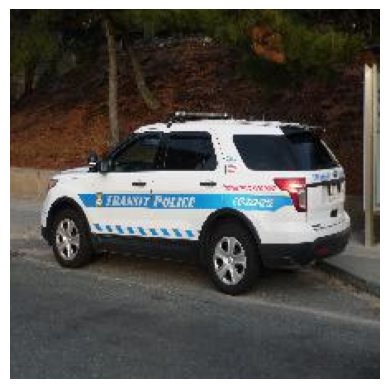

In [3]:
# Show first image
image = cv2.imread('./datasets/emergency_vehicles/labelled/emergency/1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image.shape)
plt.axis('off')
plt.imshow(image)
plt.show()

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224)
])

In [5]:
TRAIN_SIZE = 0.7

dataset = torchvision.datasets.ImageFolder('datasets/emergency_vehicles/labelled', transform)

train_idx, val_idx = train_test_split(np.arange(len(dataset)),
                                           train_size=TRAIN_SIZE, 
                                           random_state=SEED, 
                                           stratify=dataset.targets)

train_data = torch.utils.data.Subset(dataset, train_idx)
val_data = torch.utils.data.Subset(dataset, val_idx)

print('Dataset Size:', len(dataset))
print('Train Data Size:', len(train_data))
print('Validation Data Size:', len(val_data))

Dataset Size: 1646
Train Data Size: 1152
Validation Data Size: 494


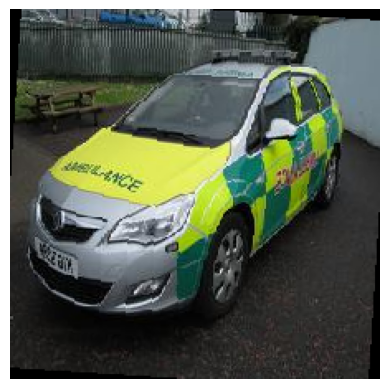

Label: 0


In [6]:
# Some quick sanity checks
for img, label in dataset:
    plt.axis('off')
    plt.imshow(img.permute(1,2,0))
    plt.show()
    print('Label: {}'.format(label)) # Emergency vehicles have label 0; non-emergency have label 1
    break

In [7]:
# Create dataloaders
BATCH_SIZE = 50

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

### Train Model

In [8]:
from models.model import Resnet18, CNNClassifier

model = CNNClassifier(num_classes=2)
# model = Resnet18()
lr = 0.008
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [9]:
def train(model, data_loader, criterion, optimizer):
    model.train()
    model.to(device)

    running_loss = 0.
    running_steps = 0
    n_correct = 0
    n_total = 0

    with tqdm(data_loader, desc ="   train") as train_tqdm:
        for inputs, targets in train_tqdm:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_steps += 1

            _, pred = torch.max(outputs, 1)
            n_correct += (pred==targets).sum().item()
            n_total += len(targets)

            average_train_loss = running_loss / running_steps
            accuracy = n_correct / n_total * 100.

            train_tqdm.set_postfix(loss=average_train_loss, accuracy=accuracy)

    return average_train_loss, accuracy

In [10]:
@torch.no_grad()
def test(model, data_loader, criterion, optimizer):
    model.eval()
    model.to(device)

    running_loss = 0.
    running_steps = 0
    n_correct = 0
    n_total = 0

    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for inputs, targets in test_tqdm:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            running_loss += loss.item()
            running_steps += 1

            _, pred = torch.max(outputs, 1)
            n_correct += (pred==targets).sum().item()
            n_total += len(targets)
    
        average_test_loss = running_loss / running_steps
        accuracy = n_correct / n_total * 100.

        test_tqdm.set_postfix(loss=average_test_loss, accuracy=accuracy)

    return average_test_loss, accuracy

In [11]:
for i in range(2):
    train_avg_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    if (i+1)%10 == 0:
        val_avg_loss, val_accuracy = test(model, val_loader, criterion, optimizer)
        print('Epoch: {:3d}, Train Average Loss: {:.2f}, Train Accuracy: {:.1f}%, Validation Average Loss: {:.2f}, Validation Accuracy: {:.1f}%'\
              .format(i+1, train_avg_loss, train_accuracy, val_avg_loss, val_accuracy))

   train:   0%|          | 0/24 [00:00<?, ?it/s]

   train: 100%|██████████| 24/24 [02:17<00:00,  5.73s/it, accuracy=49.7, epoch=24, loss=0.812]


In [13]:
val_avg_loss, val_accuracy = test(model, val_loader, criterion, optimizer)
print('Validation Average Loss: {:.2f}, Validation Accuracy: {:.1f}%'\
             .format(val_avg_loss, val_accuracy))

   test: 100%|██████████| 10/10 [00:18<00:00,  1.80s/it]

Validation Average Loss: 1.45, Validation Accuracy: 57.1%


### Save Model Parameters

In [14]:
torch.save(model.state_dict(), './models/emergency_vehicles.pth')